100.0%
100.0%
100.0%
100.0%


🔵 Training normal model (5 epochs)...
🔴 Training overfit model (50 epochs)...


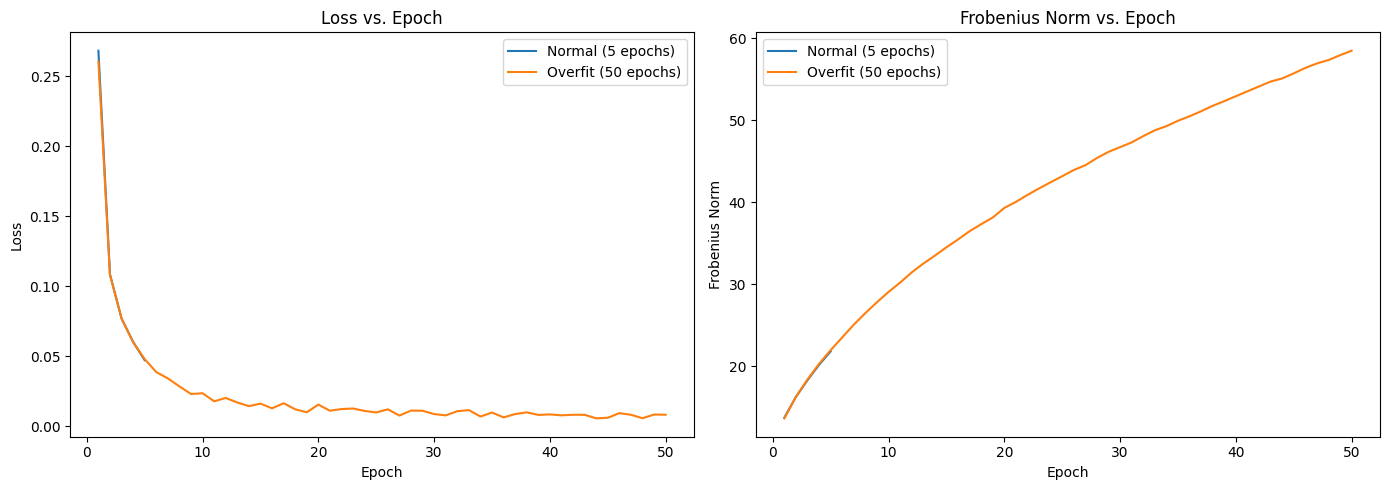

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

class ThreeLayerNN(nn.Module):
    def __init__(self, input_size=784, hidden1=128, hidden2=64, output_size=10):
        super(ThreeLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2, output_size)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        return self.fc3(x)

def compute_frobenius_norm(model):
    weights = [param for name, param in model.named_parameters() if 'weight' in name]
    all_weights = torch.cat([w.flatten() for w in weights])
    return torch.norm(all_weights, p=2).item()

def train_model(model, loader, epochs, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses, norms = [], []

    for epoch in range(epochs):
        epoch_loss = 0.0
        for images, labels in loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * images.size(0)

        avg_loss = epoch_loss / len(loader.dataset)
        losses.append(avg_loss)
        norms.append(compute_frobenius_norm(model))
    
    return model, losses, norms

print("🔵 Training normal model (5 epochs)...")
model_normal = ThreeLayerNN()
model_normal, normal_losses, normal_norms = train_model(model_normal, train_loader, epochs=5)

print("🔴 Training overfit model (50 epochs)...")
model_overfit = ThreeLayerNN()
model_overfit, overfit_losses, overfit_norms = train_model(model_overfit, train_loader, epochs=50)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 6), normal_losses, label="Normal (5 epochs)")
plt.plot(range(1, 51), overfit_losses, label="Overfit (50 epochs)")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 6), normal_norms, label="Normal (5 epochs)")
plt.plot(range(1, 51), overfit_norms, label="Overfit (50 epochs)")
plt.title("Frobenius Norm vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Frobenius Norm")
plt.legend()

plt.tight_layout()
plt.show()
